<h1>Stochastic gradient discent</h1>

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Utils
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

def f(w, xhat):
    return sigmoid(xhat.T @ w)

def grad_f(w, xhat):
    return (sigmoid(xhat.T @ w) * (1 - sigmoid(xhat.T @ w)) * xhat.T)

def MSE(f_w_x, y):
    return np.linalg.norm((f_w_x-y))**2

def grad_MSE(grad_f_w_x, f_w_x, y):
    return grad_f_w_x.T * (f_w_x - y)

def ell(w, X, Y):
    d, N = X.shape

    mse_sum = 0
    for i in range(0, N):
        mse_sum+=MSE(f(w, X[:, i]), Y[i])

    return mse_sum / N

def grad_ell(w, X, Y):
    d, N = X.shape

    grad_mse_sum = 0
    for i in range(0, N):
        grad_mse_sum += grad_MSE(np.array(grad_f(w, X[:, i])), f(w, X[:, i]), Y[i])

    return grad_mse_sum / N


In [159]:
def x_split(X, Y, N_train):
    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest

def get_digits(X, Y, chosen_numbers):
    I = [idx for idx, elem in enumerate(Y) if elem in chosen_numbers]
    X_def = X[:, I]
    Y_def = Y[I]
    
    return X_def, Y_def

In [160]:
def SGD(l, grad_l, w0, D, batch_size, n_epochs):
    alpha = 1e-3

    X, Y = D
    X_backup = X
    Y_backup = Y
    d, N = X.shape

    Xhat = np.concatenate((np.ones((1,N)), X), axis=0)

    n_batch_per_epoch = N // batch_size
    w_vals = [w0]
    f_vals = [l(w0, Xhat, Y)]
    grad_f_vals = [grad_l(w0, Xhat, Y)]
    err_vals = [np.linalg.norm(grad_l(w0, Xhat, Y))]

    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)

        for k in range(n_batch_per_epoch):
            batch_indices = idx[k * batch_size : (k + 1) * batch_size]

            Mx = Xhat[:, batch_indices]
            My = Y[batch_indices]
            M = (Mx, My)


            w = w0 - alpha * grad_l(w0, Mx, My)
            w_vals.append(w)

            w0 = w

        X = X_backup
        Y = Y_backup
        f_vals.append(l(w, Xhat, Y))
        grad_f_vals.append(grad_l(w, Xhat, Y))
        err_vals.append(np.linalg.norm(grad_l(w, Xhat, Y)))
    
    return w, f_vals, grad_f_vals, err_vals


In [161]:
import pandas as pd

In [162]:
data = pd.read_csv("./data.csv")
data = np.array(data)

In [163]:
X = data[:, 1:].T
Y = data[:, 0]

chosen_digits = [1, 2]

In [164]:
X_set, Y_set = get_digits(X, Y, chosen_digits)

In [165]:
d, N = X_set.shape
N_train = int(N/3*2)
Y_set[Y_set == chosen_digits[0]] = 0
Y_set[Y_set == chosen_digits[1]] = 1

X_train, X_test, Y_train, Y_test = x_split(X_set, Y_set, N_train)

D = (X_train, Y_train)

In [166]:
d, N = X_train.shape
w0 = np.random.normal(0, 0.1, d+1)
batch_size = 15
n_epochs = 50
w, f_vals, grad_vals, err_vals = SGD(ell, grad_ell, w0, D, batch_size, n_epochs)

<ipython-input-158-ff5f3fb470f4>:6: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-z)))


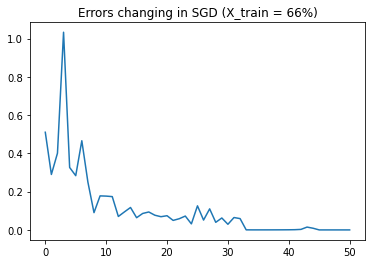

In [167]:
x_plot = np.arange(n_epochs+1)
plt.plot(x_plot, err_vals)
plt.title("Errors changing in SGD (X_train = 66%)")
plt.show()

In [168]:
def acc(app, Y, chosen_indeces):
    tot = 0
    for i in range(len(Y)):
        if (int(app[i]) == Y[i]):
            tot+=1
    return tot, tot/len(Y)

def predict(w, X, threshold = 0.5):
    d, N = X.shape
    app = np.zeros(N)
    for i in range(N):
        result = f(w, X[:, i])
        if (result >= threshold):
            app[i] = 1
        else:
            app[i] = 0
    return app

In [169]:
Xt = X_train.copy()
Yt = Y_train.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Train Set:", int(tot))
print("Total entries on Train Set:", int(Yt.shape[0]))
print("Accuracy on Train Set:", round(avg*100, 2))

Xt = X_test.copy()
Yt = Y_test.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Test Set:", int(tot))
print("Total entries on Test Set:", int(Yt.shape[0]))
print("Accuracy on Test Set:", round(avg*100, 2))

Matches on Train Set: 5814
Total entries on Train Set: 5907
Accuracy on Train Set: 98.43
Matches on Test Set: 2918
Total entries on Test Set: 2954
Accuracy on Test Set: 98.78


In [170]:
def GD_2(l, grad_l, w0, D, tolf = 1e-9, tolx= 1e-9, kmax = 50, alpha = 1e-1):
    X, Y = D
    d, N = X.shape

    Xhat = np.concatenate((np.ones((1,N)), X), axis=0)
    
    w_vals = [w0]
    f_vals = [l(w0, Xhat, Y)]
    grad_f_vals = [grad_l(w0, Xhat, Y)]
    err_vals = [np.linalg.norm(grad_l(w0, Xhat, Y))]

    iterations = 0

    while iterations < kmax:
        w = w_vals[-1] - alpha * grad_l(w_vals[-1], Xhat, Y)

        w_vals.append(w)
        f_vals.append(l(w, Xhat, Y))
        grad_f_vals.append(grad_l(w, Xhat, Y))
        err_vals.append(np.linalg.norm(grad_l(w, Xhat, Y)))

        iterations+=1

        if err_vals[-1] < tolf * err_vals[0]:
            break

        if np.linalg.norm(w_vals[-1] - w_vals[-2]) < tolx * np.linalg.norm(w_vals[0]):
            break

    return (w, f_vals, grad_f_vals, err_vals, iterations)
    

In [171]:
w_gd, f_vals_gd, grad_vals_gd, err_vals_gd, iterations_gd = GD_2(ell, grad_ell, w0, D)

<ipython-input-158-ff5f3fb470f4>:6: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-z)))


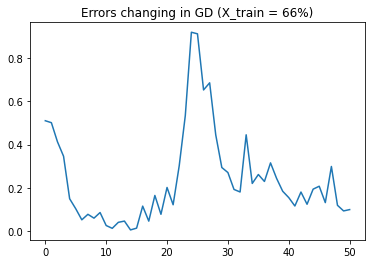

In [172]:
x_plot = np.arange(len(err_vals_gd))
plt.plot(x_plot, err_vals_gd)
plt.title("Errors changing in GD (X_train = 66%)")
plt.show()

In [173]:
Xt = X_train.copy()
Yt = Y_train.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w_gd, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Train Set:", int(tot))
print("Total entries on Train Set:", int(Yt.shape[0]))
print("Accuracy on Train Set:", round(avg*100, 2))

Xt = X_test.copy()
Yt = Y_test.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w_gd, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Test Set:", int(tot))
print("Total entries on Test Set:", int(Yt.shape[0]))
print("Accuracy on Test Set:", round(avg*100, 2))

Matches on Train Set: 5703
Total entries on Train Set: 5907
Accuracy on Train Set: 96.55
Matches on Test Set: 2857
Total entries on Test Set: 2954
Accuracy on Test Set: 96.72


In [174]:
# Change digits
X = data[:, 1:].T
Y = data[:, 0]

chosen_digits = [1, 2]

In [175]:
X_set, Y_set = get_digits(X, Y, chosen_digits)

In [176]:
# Change the dimension of train set
d, N = X_set.shape
N_train = int(N/4*3)
Y_set[Y_set == chosen_digits[0]] = 0
Y_set[Y_set == chosen_digits[1]] = 1

X_train, X_test, Y_train, Y_test = x_split(X_set, Y_set, N_train)

D = (X_train, Y_train)

In [177]:
d, N = X_train.shape
w0 = np.random.normal(0, 0.1, d+1)
batch_size = 15
n_epochs = 50
w, f_vals, grad_vals, err_vals = SGD(ell, grad_ell, w0, D, batch_size, n_epochs)

<ipython-input-158-ff5f3fb470f4>:6: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-z)))


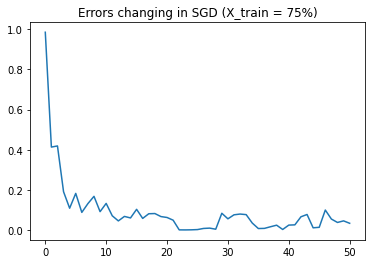

In [178]:
x_plot = np.arange(n_epochs+1)
plt.plot(x_plot, err_vals)
plt.title("Errors changing in SGD (X_train = 75%)")
plt.show()

In [179]:
Xt = X_train.copy()
Yt = Y_train.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Train Set:", int(tot))
print("Total entries on Train Set:", int(Yt.shape[0]))
print("Accuracy on Train Set:", round(avg*100, 2))

Xt = X_test.copy()
Yt = Y_test.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Test Set:", int(tot))
print("Total entries on Test Set:", int(Yt.shape[0]))
print("Accuracy on Test Set:", round(avg*100, 2))

Matches on Train Set: 6579
Total entries on Train Set: 6645
Accuracy on Train Set: 99.01
Matches on Test Set: 2177
Total entries on Test Set: 2216
Accuracy on Test Set: 98.24


<ipython-input-158-ff5f3fb470f4>:6: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-z)))


In [180]:
w_gd, f_vals_gd, grad_vals_gd, err_vals_gd, iterations_gd = GD_2(ell, grad_ell, w0, D)

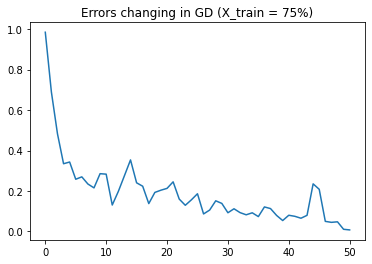

In [181]:
x_plot = np.arange(len(err_vals_gd))
plt.plot(x_plot, err_vals_gd)
plt.title("Errors changing in GD (X_train = 75%)")
plt.show()

In [182]:
Xt = X_train.copy()
Yt = Y_train.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w_gd, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Train Set:", int(tot))
print("Total entries on Train Set:", int(Yt.shape[0]))
print("Accuracy on Train Set:", round(avg*100, 2))

Xt = X_test.copy()
Yt = Y_test.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w_gd, Xthat)
tot, avg = acc(app, Yt, chosen_digits)
print("Matches on Test Set:", int(tot))
print("Total entries on Test Set:", int(Yt.shape[0]))
print("Accuracy on Test Set:", round(avg*100, 2))

Matches on Train Set: 6550
Total entries on Train Set: 6645
Accuracy on Train Set: 98.57
Matches on Test Set: 2161
Total entries on Test Set: 2216
Accuracy on Test Set: 97.52
